# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [209]:
!pip install timm

In [210]:
class CFG:
    debug        = False
    device       = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
    nprocs       = 1 # [1, 8]
    num_workers  = 4
    model_name   = 'tf_efficientnet_b3_ns' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b3_ns']
    size         = 512  # [64, 128, 224, 384, 512]
    train        = True
    freeze       = True # this is updated during training    
    epochs       = 1 # freeze_epo + gradual_unfreez_epo 
    epochsNx     = 4
    min_unfreez_layer = 2 # allowed to unfreeze layers 11 to 5 only and not less than 5
    max_layer_no = 11 # for ViT
    criterion    = 'BCEWithLogitsLoss'    # ['SmoothBCEwithLogits', 'CrossEntropyLoss', 'BCEWithLogitsLoss']
    batch_size   = 10 #[32, 64]
    weight_decay = 1e-6
    max_grad_norm= 1
    tta          = 3 
    seed         = 42
    target_size  = -1    # init below
    n_fold       = 5
    train_fold   = [0] #, 1, 2, 3, 4]
    # infer_fold = [0, 1, 2, 3, 4]
    smoothing    = 0.1
    img_ext      = '.jpg'
    img_col      = "StudyInstanceUID"
    label_cols   = [
                    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                    'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                    'Swan Ganz Catheter Present'
    ]
    model_infer_path_prefix = "." #"../input/tf-efficientnet-b4-ns-88"
    model_train_path_prefix = "."
    train_path   = '../input/ranzcr-clip-catheter-line-classification/train'
    train_csv    = '../input/ranzcr-clip-catheter-line-classification/train.csv'
    test_path    = '../input/ranzcr-clip-catheter-line-classification/test'
    test_csv     = '../input/ranzcr-clip-catheter-line-classification/test.csv'
    output_dir   = 'Output/'
    
    freeze_epo   = 1 # after these epochs, gradually unfreeze top layers
    gradual_unfreez_epo = 7
    IMG_MEAN     = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD      = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]            
    
CFG.target_size = len (CFG.label_cols)

In [211]:
!ls ../input/ranzcr-clip-catheter-line-classification

sample_submission.csv  test_tfrecords  train.csv	      train_tfrecords
test		       train	       train_annotations.csv


In [212]:
import os
import gc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
import math

import fastai
from   fastai.callback.mixup import MixUp, CutMix
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.data.core import *
from   fastai.data.load import *
from   fastai.learner import Learner
from   fastai.metrics import *
from   fastai.optimizer import OptimWrapper 
from   fastai.losses import LabelSmoothingCrossEntropy

# from   warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

In [213]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [214]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Augmentation Dataset

In [215]:
train_transforms = A.Compose ([
        A.HorizontalFlip (p=0.5),
        A.CoarseDropout (p=0.5),
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])
valid_transforms = A.Compose ([
        A.HorizontalFlip (p=0.45),
        A.CoarseDropout (p=0.5),
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return train_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [216]:
class ImgDataset (Datasets):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super (ImgDataset, self).__init__(df.reset_index(drop=True), tfms=None, n_inp=1)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.items.shape[0]
    
    def __getitem__(self, idx):
        
        file_name = self.items[self.img_file_colname][idx] + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.items.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [217]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


4920

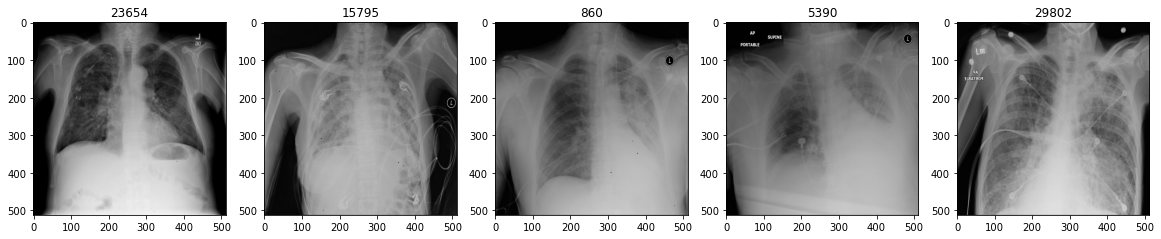

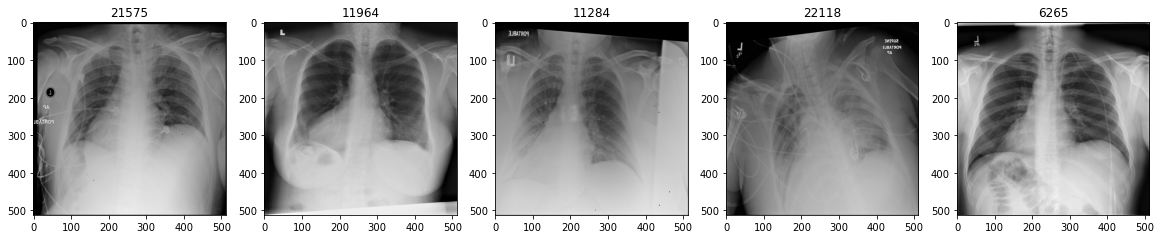

In [218]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                                    ;print (img.size())
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [219]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [220]:
def get_criterion ():
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss ()
    return criterion

In [221]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model (CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT(nn.Module):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False, 
                 min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        self.min_unfreez_layer = min_unfreez_layer
        self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    def unfreeze_layer (self, layer_no=11):
        # unfreeze a particular layer
        if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
            for param in self.model.blocks[layer_no].parameters ():
                param.requires_grad = False
        return

In [222]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        model.load_state_dict (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
        state_dict = torch.load (model_path)['model']
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [223]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates (subplots)
def plot_metrics (self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil (n / ncols))
    elif ncols is None: ncols = int(np.ceil (n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots (nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate (axs.flatten())][:n]
    for i, (name, ax) in enumerate (zip (names, [axs[0]] + axs)):
        ax.plot (metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title (name if i > 1 else 'losses')
        ax.legend (loc='best')
    plt.show ()

In [224]:
@delegates (torch.optim.AdamW.__init__)
def pytorch_AdamW (param_groups, **kwargs):
    return OptimWrapper (torch.optim.AdamW ([{'params': ps, **kwargs} for ps in param_groups]))

In [225]:
class UnfreezeCallback (Callback):
    
    def __init__(self, freeze_epo=CFG.freeze_epo, max_layer_no=CFG.max_layer_no):
        super().__init__()
        self.freeze_epo   = freeze_epo
        self.max_layer_no = max_layer_no
        return
        
    def before_epoch (self): 
        if self.epoch >= self.freeze_epo:
            self.learn.model.unfreeze_layer (self.max_layer_no - (self.epoch-self.freeze_epo))

In [226]:
def getModel (fold, isTrain=True):
    
    model = None
    if 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)   # TODO pretrained=isTrain    
    if isTrain:
        
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        if os.path.exists (model_path):
          load_state (model_path, model)  
        # TODO: comment this
        # model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}.pth'
        # load_state (model_path, model)
        # torch.save (model.state_dict (), f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}.pth')
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [231]:
def fit_epochs (fold, callbacks, learn, max_acc, start_lr=1e-6, end_lr=5e-5):
    
    # lr_min = 1e-5
    lr_min, _   = learn.lr_find (start_lr=start_lr, end_lr=end_lr, num_it=100) 
    print ('lr_min =', lr_min)
    lr          = lr_min
    model       = getModel (fold, isTrain=True).to (CFG.device)
    learn.model = model
    learn.fit_one_cycle (CFG.epochs, lr, wd=CFG.weight_decay, cbs=callbacks)
    learn.recorder.plot_metrics ()
    # learn.recorder.plot_lr ()        
    acc = learn.recorder.metrics[0].value.numpy ()
    if acc > max_acc:
        max_acc = acc
        learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    return max_acc

In [232]:
def train_fold_loop (fold, train_df=getFolds ()):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index

    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)    
    loss_func      = get_criterion ()
    model          = getModel (fold, isTrain=True)
    model          = model.float().to (CFG.device)
    modelfile      = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}'
    size           = CFG.size
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))
    train_datlder  = DataLoader (train_dataset, batch_size=CFG.batch_size, device=CFG.device)
    valid_datlder  = DataLoader (valid_dataset, batch_size=CFG.batch_size, device=CFG.device)
    dls            = DataLoaders (train_datlder, valid_datlder, device=CFG.device)
    learn          = Learner (dls, model, loss_func=loss_func, model_dir=f'{CFG.model_train_path_prefix}',
                     opt_func=partial (pytorch_AdamW, lr=0.007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
                     metrics=[accuracy, error_rate])   #fbeta, auc_roc_score
    print (learn.summary ())
    
    # initially cfg.freeze=True, but only for the 1st time, at end it is =False to train the deep layers
    max_acc = 0
    for i in range (CFG.epochsNx):
        
        if i < 2:            
            start_lr, end_lr = 1e-4, 5e-3
        else:            
            start_lr, end_lr = 1e-5, 5e-4
        
        callbacks = [
            EarlyStoppingCallback (monitor='accuracy', min_delta=0.0001, patience=2),
            SaveModelCallback     (monitor='accuracy', fname=modelfile),
            ReduceLROnPlateau     (monitor='accuracy', min_delta=0.001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.max_grad_norm),
            # MixUp (),
            # CutMix (),
        ]
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
        CFG.freeze = False
    return valid_scores

In [233]:
def train_main ():
    
    if CFG.train:
        
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        LOGGER.info (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

In [ ]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log

gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*efficient*', pretrained=True)
# pprint (model_names)

LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========
========== fold: 0 training ==========


CustomEfficientNet (Input shape: 10)
Layer (type)         Output Shape         Param #    Trainable 
                     10 x 40 x 256 x 256 
Conv2dSame                                1080       False     
BatchNorm2d                               80         False     
SiLU                                                           
Conv2d                                    360        False     
BatchNorm2d                               80         False     
SiLU                                                           
____________________________________________________________________________
                     10 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     10 x 40 x 1 x 1     
Conv2d                                    440        False     
___________________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time


# Inference

In [ ]:
def compute_metrics (labels, preds):
    
    # preds   = pred_pr.argmax (-1)             # ;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    # softmax = nn.Softmax (dim=1)
    # pred_pr = softmax (torch.tensor (pred_logits))
    # auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        #'auc'     : auc
    }
    return metrics

In [ ]:
class TorchCassavaDataset (torch.utils.data.Dataset):
    
    def __init__(self, df, transform=get_transforms('valid'), path=CFG.test_path, isLabel=False):
        
        super ().__init__()
        self.df         = df
        self.file_names = df['image_id'].values
        self.transform  = transform
        self.path       = path
        self.isLabel    = isLabel
        if isLabel:
            self.labels = df['label'].values
        return
        
    def __len__(self):        
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        file_name = self.file_names[idx]
        file_path = f'{self.path}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform (image=image)
            image     = augmented['image']
        
        if self.isLabel:
            label = torch.tensor (self.labels[idx]).long ()
            return image, label
        return image

In [ ]:
def inference_one_loop (model, data_loader, device):
    model.eval ()
    image_preds_all = []
    pbar = tqdm (enumerate (data_loader), total=len (data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to (device).float ()
        
        image_preds = model (imgs) 
        image_preds_all += [torch.softmax (image_preds, 1).detach ().cpu ().numpy ()]
    
    image_preds_all = np.concatenate (image_preds_all, axis=0)
    return image_preds_all

In [ ]:
def infer ():
    
    CFG.freeze = True
    tst_preds_avg = []    
    seed_everything (CFG.seed)
    test_df = pd.DataFrame ()
    test_df['image_id'] = list (os.listdir (CFG.test_path))
    test_ds = TorchCassavaDataset (test_df)             #;print ('len (test_ds) =', len (test_ds)) ;print ('test_ds[10].shape =', test_ds[10].shape)
    tst_loader = torch.utils.data.DataLoader (
        test_ds, 
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
        pin_memory=False,
    )                                            #;print ('len (tst_loader)=', len (tst_loader))
    device = DEVICE  # torch.device (CFG.device)
    for fold in CFG.train_fold:
        
        print ('Inference fold {} started'.format (fold))
        model     = getModel (fold, isTrain=False).to (device)
        tst_preds = []        
        with torch.no_grad ():
            for _ in range (CFG.tta):
                
                tst_preds += [1/CFG.tta * inference_one_loop (model, tst_loader, device)]
        
        tst_preds_avg.append (np.mean (tst_preds, axis=0))
        del model
        torch.cuda.empty_cache ()
        gc.collect ()
    
    test_df['label'] = np.argmax (np.mean (tst_preds_avg, axis=0), axis=-1)
    print (test_df.head ())
    test_df.to_csv ('submission.csv', index=False)

In [ ]:
print ('Done !')